#### 2. 尝试encoder hidden state不同的返回形式（concat和add）


In [11]:
def read_data(in_file, out_file):
    """
    读取训练数据返回数据集合
    """
    enc_data,dec_data = [],[]
    with open(in_file) as f_in:
        # 读取记录行
        lines_in = f_in.read().split('\n')
        for line in lines_in:
            if line == '':
                continue
            # 分词

            enc_tks = line.split()
            # 保存
            enc_data.append(enc_tks)

    with open(out_file) as f_out:
        # 读取记录行
        lines_out = f_out.read().split('\n')
        for line in lines_out:
            if line == '':
                continue
            # 分词
            out_tks = line.split()
            dec_tks = ['BOS'] + list(out_tks) + ['EOS']

            # 保存
            dec_data.append(dec_tks)

    # 断言
    print('enc_data:', len(enc_data),enc_data)
    print('dec_data:', len(dec_data),dec_data)
    assert len(enc_data) == len(dec_data), '编码数据与解码数据长度不一致！'
    return enc_data, dec_data

enc_data,dec_data = read_data('/Users/peiqi/code/AiPremiumClass/李思佳/week08/couplet/test/in.txt','/Users/peiqi/code/AiPremiumClass/李思佳/week08/couplet/test/out.txt')


enc_data: 4000 [['腾', '飞', '上', '铁', '，', '锐', '意', '改', '革', '谋', '发', '展', '，', '勇', '当', '千', '里', '马'], ['风', '弦', '未', '拨', '心', '先', '乱'], ['花', '梦', '粘', '于', '春', '袖', '口'], ['晋', '世', '文', '章', '昌', '二', '陆'], ['一', '句', '相', '思', '吟', '岁', '月'], ['几', '树', '梅', '花', '数', '竿', '竹'], ['未', '舍', '东', '江', '开', '口', '咏'], ['彩', '屏', '如', '画', '，', '望', '秀', '美', '崤', '函', '，', '花', '团', '锦', '簇'], ['玉', '液'], ['珍', '藏', '惟', '有', '诗', '三', '卷'], ['岁', '尽', '方', '知', '时', '日', '快'], ['路', '不', '拾', '遗', '，', '夜', '不', '闭', '户'], ['国', '家', '至', '上', '，', '讨', '袁', '抗', '日', '，', '丰', '碑', '两', '座', '彰', '军', '史'], ['无', '花', '无', '酒', '无', '花', '酒'], ['薰', '风', '生', '殿', '阁'], ['马', '齿', '草', '焉', '无', '马', '齿'], ['潮', '白', '河', '边', '，', '紫', '燕', '剪', '裁', '美', '画', '图', '，', '绿', '为', '底', '色'], ['路', '边', '鸡', '放', '哨'], ['天', '古', '天', '今', '，', '地', '中', '地', '外', '，', '古', '今', '中', '外', '存', '天', '地'], ['释', '怀', '心', '见', '佛'], ['与', '地', '增', '春', '，', '其', '熙', '长', '趣'

In [13]:
import torch
from torch.nn.utils.rnn import pad_sequence
# 构建词典
class Vocabulary:

    def __init__(self, vocab):
        self.vocab = vocab

    @classmethod
    def from_documents(cls, documents):
        # 字典构建（字符为token、词汇为token）
        no_repeat_tokens = set()
        for cmt in documents:
            no_repeat_tokens.update(list(cmt))  # token list
        # set转换为list，第0个位置添加统一特殊token
        tokens = ['PAD','UNK'] + list(no_repeat_tokens)

        vocab = { tk:i for i, tk in enumerate(tokens)}

        return cls(vocab)
    
#回调函数
def get_proc(enc_voc, dec_voc):

    # 嵌套函数定义
    # 外部函数变量生命周期会延续到内部函数调用结束 （闭包）

    def batch_proc(data):
        """
        批次数据处理并返回
        """
        enc_ids, dec_ids, labels = [],[],[]
        for enc,dec in data:
            # token -> token index
            enc_idx = [enc_voc[tk] for tk in enc]
            dec_idx = [dec_voc[tk] for tk in dec]

            # encoder_input
            enc_ids.append(torch.tensor(enc_idx))
            # decoder_input
            dec_ids.append(torch.tensor(dec_idx[:-1]))
            # label
            labels.append(torch.tensor(dec_idx[1:]))

        
        # 数据转换张量 [batch, max_token_len]
        # 用批次中最长token序列构建张量
        enc_input = pad_sequence(enc_ids, batch_first=True)
        dec_input = pad_sequence(dec_ids, batch_first=True)
        targets = pad_sequence(labels, batch_first=True)

        # 返回数据都是模型训练和推理的需要
        return enc_input, dec_input, targets

    # 返回回调函数
    return batch_proc

In [14]:
from torch.utils.data import DataLoader
import json
import pickle


enc_vocab = Vocabulary.from_documents(enc_data)
dec_vocab = Vocabulary.from_documents(dec_data)

print(enc_vocab.vocab)
print(dec_vocab.vocab)


print('编码器词汇数量', len(enc_vocab.vocab))
print('解码器词汇数量', len(dec_vocab.vocab))


# 数据缓存
# 数据整体json数据集（json）
with open('encoder.json', 'w', encoding='utf-8') as f:
    json.dump(enc_data, f)  

with open('decoder.json', 'w', encoding='utf-8') as f:
    json.dump(dec_data, f)  

with open('vocab.bin','wb') as f:
    pickle.dump((enc_vocab.vocab, dec_vocab.vocab),f)


{'PAD': 0, 'UNK': 1, '猜': 2, '韩': 3, '医': 4, '伐': 5, '腮': 6, '聚': 7, '岚': 8, '轩': 9, '凉': 10, '纤': 11, '眺': 12, '产': 13, '旦': 14, '蘸': 15, '挟': 16, '媒': 17, '托': 18, '灭': 19, '朵': 20, '忌': 21, '碰': 22, '薪': 23, '献': 24, '拐': 25, '圈': 26, '荼': 27, '次': 28, '乍': 29, '陬': 30, '墓': 31, '踏': 32, '印': 33, '祭': 34, '徒': 35, '棋': 36, '吗': 37, '迁': 38, '枪': 39, '想': 40, '契': 41, '讴': 42, '刻': 43, '兵': 44, '腊': 45, '酹': 46, '灯': 47, '禁': 48, '谨': 49, '舆': 50, '班': 51, '密': 52, '勃': 53, '哦': 54, '彰': 55, '祥': 56, '梨': 57, '赊': 58, '珰': 59, '侍': 60, '略': 61, '绩': 62, '伴': 63, '孝': 64, '袁': 65, '匹': 66, '抱': 67, '普': 68, '缎': 69, '询': 70, '谊': 71, '陆': 72, '蛮': 73, '丛': 74, '立': 75, '彻': 76, '荒': 77, '榕': 78, '煅': 79, '缈': 80, '叮': 81, '娇': 82, '掏': 83, '彩': 84, '晋': 85, '芥': 86, '消': 87, '梓': 88, '嫩': 89, '智': 90, '倒': 91, '棉': 92, '颁': 93, '市': 94, '人': 95, '典': 96, '件': 97, '侠': 98, '型': 99, '殿': 100, '凯': 101, '载': 102, '俯': 103, '拳': 104, '栖': 105, '汉': 106, '丈': 107, '绚': 108, '谷': 109, '梦': 

In [ ]:
import torch
import torch.nn as nn

# 编码器
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout):
        super(Encoder, self).__init__()
        # 定义嵌入层
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # 定义GRU层
        self.rnn = nn.GRU(emb_dim, hidden_dim,dropout=dropout, 
                          batch_first=True, bidirectional=True)


    def forward(self, token_seq, hidden_type):
        # token_seq: [batch_size, seq_len]
        # embedded: [batch_size, seq_len, emb_dim]
        embedded = self.embedding(token_seq)
        # outputs: [batch_size, seq_len, hidden_dim * 2]
        # hidden: [2, batch_size, hidden_dim]
        outputs, hidden = self.rnn(embedded)
        # 返回，Encoder最后一个时间步的隐藏状态(拼接)
        # return outputs[:, -1, :]
        # 返回最后一个时间步的隐藏状态(拼接), 所有时间步的输出（attention准备）
        if hidden_type == 'cat':
            hidden_state = torch.cat((hidden[0], hidden[1]), dim=1).unsqueeze(0)
        elif hidden_type == 'sum':
            # 使用线性层调整维度
            hidden_state = (hidden[0] + hidden[1]).unsqueeze(0)
        elif hidden_type == 'mul':
            hidden_state = (hidden[0] * hidden[1]).unsqueeze(0)
        else:
            hidden_state = torch.cat((hidden[0], hidden[1]), dim=1).unsqueeze(0)
        
        return hidden_state, outputs

        # 返回最后一个时间步的隐状态（相加）
        # return hidden.sum(dim=0)

class Attention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, enc_output, dec_output):
        # a_t = h_t @ h_s  
        a_t = torch.bmm(enc_output, dec_output.permute(0, 2, 1))
        # 1.计算 结合解码token和编码token，关联的权重
        a_t = torch.softmax(a_t, dim=1)
        # 2.计算 关联权重和编码token 贡献值
        c_t = torch.bmm(a_t.permute(0, 2, 1), enc_output)
        return c_t

# 解码器
class Decoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout):
        super(Decoder, self).__init__()
        # 定义嵌入层
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # 定义GRU层
        self.rnn = nn.GRU(emb_dim, hidden_dim * 2, dropout=dropout,
                          batch_first=True)
        # 定义线性层
        self.fc = nn.Linear(hidden_dim * 2, input_dim)  # 解码词典中词汇概率
        # attention层
        self.atteniton = Attention()
        # attention结果转换线性层
        self.atteniton_fc = nn.Linear(hidden_dim * 4, hidden_dim * 2)

    def forward(self, token_seq, hidden_state, enc_output, hidden_type='cat'):
        # token_seq: [batch_size, seq_len]
        # embedded: [batch_size, seq_len, emb_dim]
        embedded = self.embedding(token_seq)
        # outputs: [batch_size, seq_len, hidden_dim * 2]
        # hidden: [1, batch_size, hidden_dim * 2]



        dec_output, hidden = self.rnn(embedded, hidden_state)

        # attention运算
        c_t = self.atteniton(enc_output, dec_output)
        # [attention, dec_output]
        cat_output = torch.cat((c_t, dec_output), dim=-1)
        # 线性运算
        out = torch.tanh(self.atteniton_fc(cat_output))

        # out: [batch_size, seq_len, hidden_dim * 2]
        logits = self.fc(out)
        return logits, hidden

class Seq2Seq(nn.Module):

    def __init__(self,
                 enc_emb_size, 
                 dec_emb_size,
                 emb_dim,
                 hidden_size,
                 dropout=0.5,
                 hidden_type='cat' #添加hidden_type参数
                 ):
        
        super().__init__()

        # encoder
        self.encoder = Encoder(enc_emb_size, emb_dim, hidden_size, dropout=dropout)
        # decoder
        self.decoder = Decoder(dec_emb_size, emb_dim, hidden_size, dropout=dropout)
        self.hidden_type = hidden_type  # 存储 hidden_type
        self.hidden_transform = nn.Linear(hidden_size, hidden_size * 2)



    def forward(self, enc_input, dec_input):
        # encoder last hidden state
        encoder_state, outputs = self.encoder(enc_input, self.hidden_type)

        if self.hidden_type == 'sum' or self.hidden_type == 'mul' :
            encoder_state = self.hidden_transform(encoder_state)
        output,hidden = self.decoder(dec_input, encoder_state, outputs, self.hidden_type)

        return output,hidden

In [39]:
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


# 加载训练数据
with open('vocab.bin','rb') as f:
    evoc,dvoc = pickle.load(f)

with open('encoder.json') as f:
    enc_data = json.load(f)
with open('decoder.json') as f:
    dec_data = json.load(f)


ds = list(zip(enc_data,dec_data))
dl = DataLoader(ds, batch_size=10, shuffle=True, collate_fn=get_proc(evoc, dvoc))

writer = SummaryWriter()

# 定义三种不同的 hidden_type
hidden_types = ['cat', 'sum', 'mul']

# 构建训练模型
# 模型构建
models = {
    hidden_type: Seq2Seq(
        enc_emb_size=len(evoc),
        dec_emb_size=len(dvoc),
        emb_dim=100,
        hidden_size=120,
        dropout=0.5,
        hidden_type=hidden_type
        ) for hidden_type in hidden_types
}

# 优化器、损失
optimizers = {hidden_type : optim.Adam(model.parameters(), lr=1e-3) for hidden_type, model in models.items()}
criterion = nn.CrossEntropyLoss()

# 训练
for hidden_type, model in models.items():
    for epoch in range(20):
        model.train()
        optimizer = optimizers[hidden_type]
        tpbar = tqdm(dl, desc=f'Epoch {epoch+1} [{hidden_type}]')
        
        for i, (enc_input, dec_input, targets) in enumerate(tpbar):

            # 前向传播 
            logits, _ = model(enc_input, dec_input)

            # 计算损失
            # CrossEntropyLoss需要将logits和targets展平
            # logits: [batch_size, seq_len, vocab_size]
            # targets: [batch_size, seq_len]
            # 展平为 [batch_size * seq_len, vocab_size] 和 [batch_size * seq_len]
            loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))

            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tpbar.set_description(f'Epoch {epoch+1} [{hidden_type}], Loss: {loss.item():.4f}')
            writer.add_scalar(f'training loss/{hidden_type}', loss.item(), epoch * len(tpbar) + i)


# 保存模型
for hidden_type, model in models.items():
    torch.save(model.state_dict(), f'seq2seq_{hidden_type}_state.bin')
writer.close()


Epoch 20 [mul], Loss: 0.0941: 100%|██████████| 400/400 [00:08<00:00, 49.74it/s]


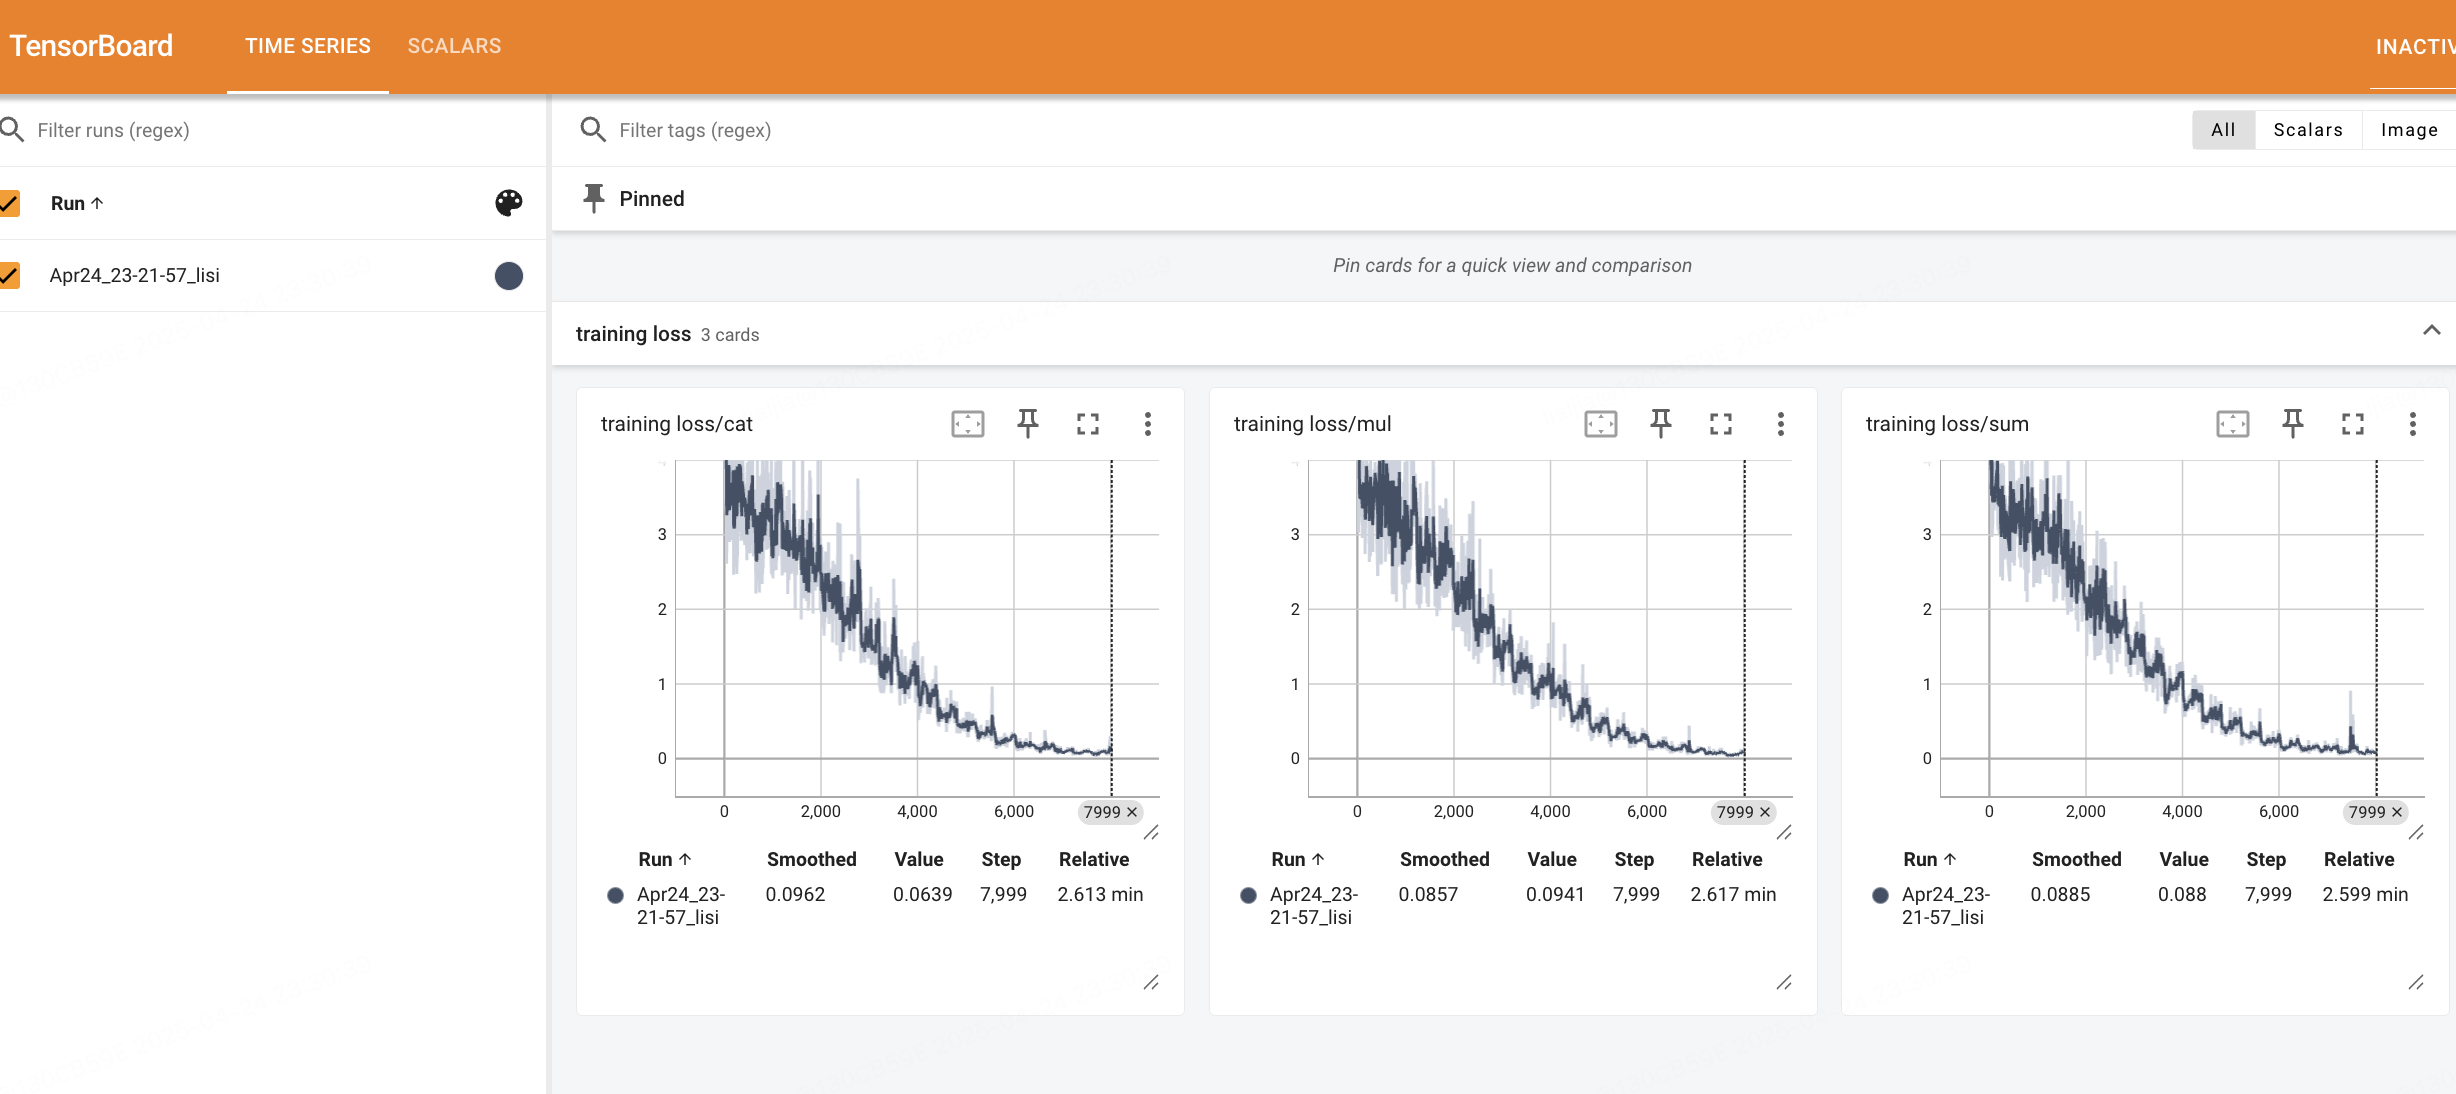